# Synthetic data

In [ ]:
!pip install sdv

In [ ]:
import sdv
print(sdv.__version__)


1.20.1


In [ ]:
import pandas as pd
from sdv.datasets.demo import download_demo
from sdv.single_table import GaussianCopulaSynthesizer


In [ ]:
data = pd.read_csv('Fast_Food_Sales.csv')

data.head()


,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale
0,1,07-03-2022,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night
1,2,8/23/2022,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon
2,3,11/20/2022,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon
3,4,02-03-2023,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night
4,5,10-02-2022,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening


In [ ]:
from sdv.metadata import SingleTableMetadata

# Generate metadata from data
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=data)


In [ ]:
# Train model from data
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data)

synthetic_data = synthesizer.sample(num_rows=9000)
print(synthetic_data)


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:144: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:122: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


      order_id        date        item_name  item_type  item_price  quantity  \
0     11716418   5/22/2022  Sugarcane juice   Fastfood          20         3   
1      7454845   4/27/2022          Frankie   Fastfood          25        10   
2      6336744   9/17/2022         Aalopuri  Beverages          20        14   
3      8756923  05-12-2022          Frankie  Beverages          25        13   
4       981668  03-02-2023  Sugarcane juice   Fastfood          60        13   
...        ...         ...              ...        ...         ...       ...   
8995   7810538   7/31/2022      Cold coffee  Beverages          40        14   
8996  14199988  04-11-2022  Sugarcane juice   Fastfood          20         3   
8997   1036684   5/20/2022          Frankie  Beverages          50         2   
8998  11255772   7/22/2022          Frankie  Beverages          25         4   
8999  13058211   8/22/2022         Panipuri  Beverages          40         4   

      transaction_amount transaction_ty

In [ ]:
synthetic_data.to_csv("synthetic_output.csv", index=False)
# files.download("synthetic_output.csv")


#  Import library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# SETUP SPARK ENVIRONMENT
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"
!pip install -q findspark
import findspark
findspark.init()

^C


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Restaurant").getOrCreate()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import count, when, isnan, col
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import to_date

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Exploratory Data Analysis (EDA)

##  Reading dataset

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/BigData_project/Dataset/Fast Food Sales Data.csv", header=True, inferSchema=True, nullValue="")

In [ ]:
df.show()
df.printSchema()

+--------+----------+---------------+---------+----------+--------+------------------+----------------+-----------+------------+
|order_id|      date|      item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+--------+----------+---------------+---------+----------+--------+------------------+----------------+-----------+------------+
|       1|07-03-2022|       Aalopuri| Fastfood|        20|      13|               260|            NULL|        Mr.|       Night|
|       2| 8/23/2022|        Vadapav| Fastfood|        20|      15|               300|            Cash|        Mr.|   Afternoon|
|       3|11/20/2022|        Vadapav| Fastfood|        20|       1|                20|            Cash|        Mr.|   Afternoon|
|       4|02-03-2023|Sugarcane juice|Beverages|        25|       6|               150|          Online|        Mr.|       Night|
|       5|10-02-2022|Sugarcane juice|Beverages|        25|       8|               200|          O

In [ ]:
# Count the number of rows and columns in the dataset
print((df.count(), len(df.columns)))

(16000, 10)


In [ ]:
df.select([countDistinct(c).alias(c) for c in df.columns]).show()

+--------+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|order_id|date|item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+--------+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|   16000| 348|        7|        2|         5|      15|               863|               2|          2|           5|
+--------+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+



In [ ]:
df.describe().show()

+-------+-----------------+----------+---------+---------+-----------------+-----------------+------------------+----------------+-----------+------------+
|summary|         order_id|      date|item_name|item_type|       item_price|         quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+-------+-----------------+----------+---------+---------+-----------------+-----------------+------------------+----------------+-----------+------------+
|  count|            16000|     16000|    16000|    16000|            16000|            16000|             16000|           14372|      16000|       16000|
|   mean|   7856781.400625|      NULL|     NULL|     NULL|        33.250625|           8.3415|       294.6948125|            NULL|       NULL|        NULL|
| stddev|5113498.478037472|      NULL|     NULL|     NULL|14.90156671805153|4.223578774404936| 205.9338139283408|            NULL|       NULL|        NULL|
|    min|                1|01-01-2023| Aalopuri|Beverages|      

**Check duplicate**

In [ ]:
# Check for duplicates by counting all rows and distinct rows
total_rows = df.count()
distinct_rows = df.distinct().count()

# Calculate the number of duplicates
duplicates = total_rows - distinct_rows
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


**Define missing value**

In [ ]:
# Check null values of the dataset
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|order_id|date|item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+--------+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|       0|   0|        0|        0|         0|       0|                 0|            1628|          0|           0|
+--------+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+



## Data Reduction

In [ ]:
df = df.drop('order_id')


In [ ]:
df.select([countDistinct(c).alias(c) for c in df.columns]).show()

+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|date|item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
| 348|        7|        2|         5|      15|               863|               2|          2|           5|
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+



## Data Cleaning/Wrangling

In [ ]:
# Drop null
df = df.dropna(subset=['transaction_type'])

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|date|item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|   0|        0|        0|         0|       0|                 0|               0|          0|           0|
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+



In [ ]:
print((df.count(), len(df.columns)))

(14372, 9)


In [ ]:
df.show()

+----------+---------------+---------+----------+--------+------------------+----------------+-----------+------------+
|      date|      item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+----------+---------------+---------+----------+--------+------------------+----------------+-----------+------------+
| 8/23/2022|        Vadapav| Fastfood|        20|      15|               300|            Cash|        Mr.|   Afternoon|
|11/20/2022|        Vadapav| Fastfood|        20|       1|                20|            Cash|        Mr.|   Afternoon|
|02-03-2023|Sugarcane juice|Beverages|        25|       6|               150|          Online|        Mr.|       Night|
|10-02-2022|Sugarcane juice|Beverages|        25|       8|               200|          Online|        Mr.|     Evening|
|11/14/2022|        Vadapav| Fastfood|        20|      10|               200|            Cash|        Mr.|     Evening|
|05-03-2022|Sugarcane juice|Beverages|  

**Statistics Summary**

In [ ]:
df.describe().show()

+-------+----------+---------+---------+------------------+-----------------+------------------+----------------+-----------+------------+
|summary|      date|item_name|item_type|        item_price|         quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+-------+----------+---------+---------+------------------+-----------------+------------------+----------------+-----------+------------+
|  count|     14372|    14372|    14372|             14372|            14372|             14372|           14372|      14372|       14372|
|   mean|      NULL|     NULL|     NULL|33.293209017534096|8.264403005844699|292.25340940718064|            NULL|       NULL|        NULL|
| stddev|      NULL|     NULL|     NULL|   14.904848432588|4.221292164073046|204.77104173683216|            NULL|       NULL|        NULL|
|    min|01-01-2023| Aalopuri|Beverages|                20|                1|                20|            Cash|        Mr.|   Afternoon|
|    max| 9/30/2022|  Vadap

## EDA Univariate Analysis



1. Numerical variables.


📊 Column: item_price
Skewness: 0.62


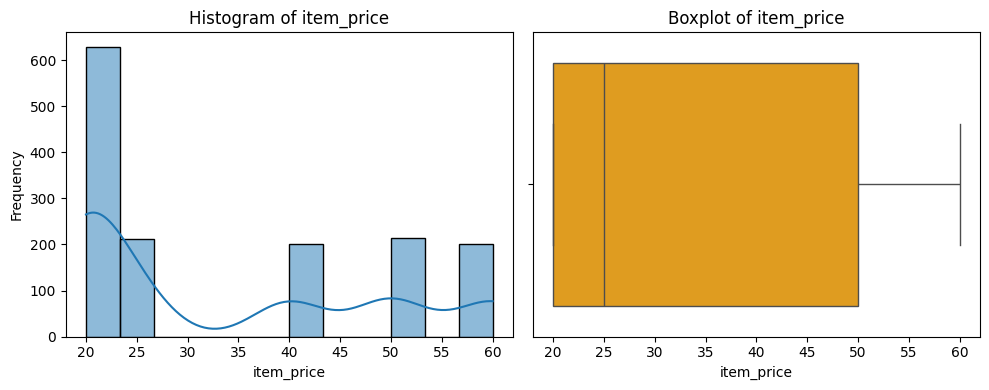


📊 Column: quantity
Skewness: -0.08


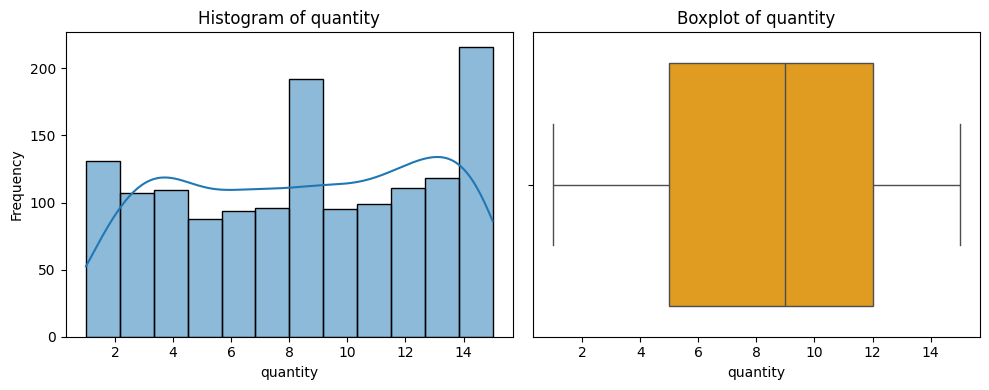


📊 Column: transaction_amount
Skewness: 0.71


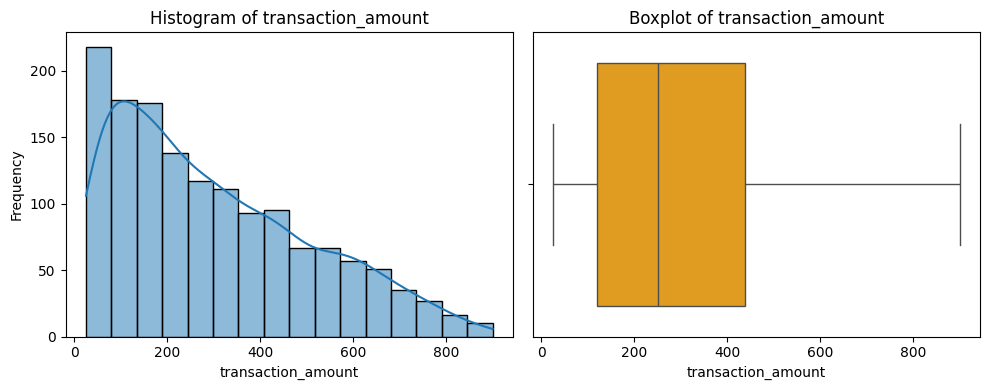

In [ ]:
numeric_cols = ["item_price", "quantity", "transaction_amount"]
categorical_cols = ["item_name", "item_type", "transaction_type", "received_by", "time_of_sale"]

# SAMPLING FROM SPARK DATAFRAME TO PANDAS
pandas_df = df.sample(withReplacement=False, fraction=0.1, seed=1).toPandas()

# NUMERICAL VARIABLE ANALYSIS
for col in numeric_cols:
    print(f"\n📊 Column: {col}")
    print("Skewness:", round(pandas_df[col].skew(), 2))

    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(pandas_df[col].dropna(), kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=pandas_df[col].dropna(), color='orange')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


2. Categorical variables.

In [ ]:
def calculate_percentage(df, column_name):
    total_count = df.count()
    percentage_df = (
        df.groupBy(column_name)
          .agg(F.count("*").alias("count"))
          .withColumn("percentage", F.round((F.col("count") / total_count) * 100, 2))
          .orderBy(F.col("count").desc())
    )
    return percentage_df


In [ ]:
for col in categorical_cols:
    print(f"\n📊 Category Analysis: {col}")

    # Calculate percentage
    pct_df = calculate_percentage(df, col)
    pct_df.show(truncate=False)


📊 Category Analysis: item_name
+---------------+-----+----------+
|item_name      |count|percentage|
+---------------+-----+----------+
|Cold coffee    |2337 |16.26     |
|Sugarcane juice|2160 |15.03     |
|Panipuri       |2106 |14.65     |
|Aalopuri       |2043 |14.22     |
|Frankie        |1971 |13.71     |
|Vadapav        |1936 |13.47     |
|Sandwich       |1819 |12.66     |
+---------------+-----+----------+


📊 Category Analysis: item_type
+---------+-----+----------+
|item_type|count|percentage|
+---------+-----+----------+
|Fastfood |9775 |68.01     |
|Beverages|4597 |31.99     |
+---------+-----+----------+


📊 Category Analysis: transaction_type
+----------------+-----+----------+
|transaction_type|count|percentage|
+----------------+-----+----------+
|Cash            |7582 |52.76     |
|Online          |6790 |47.24     |
+----------------+-----+----------+


📊 Category Analysis: received_by
+-----------+-----+----------+
|received_by|count|percentage|
+-----------+-----+----

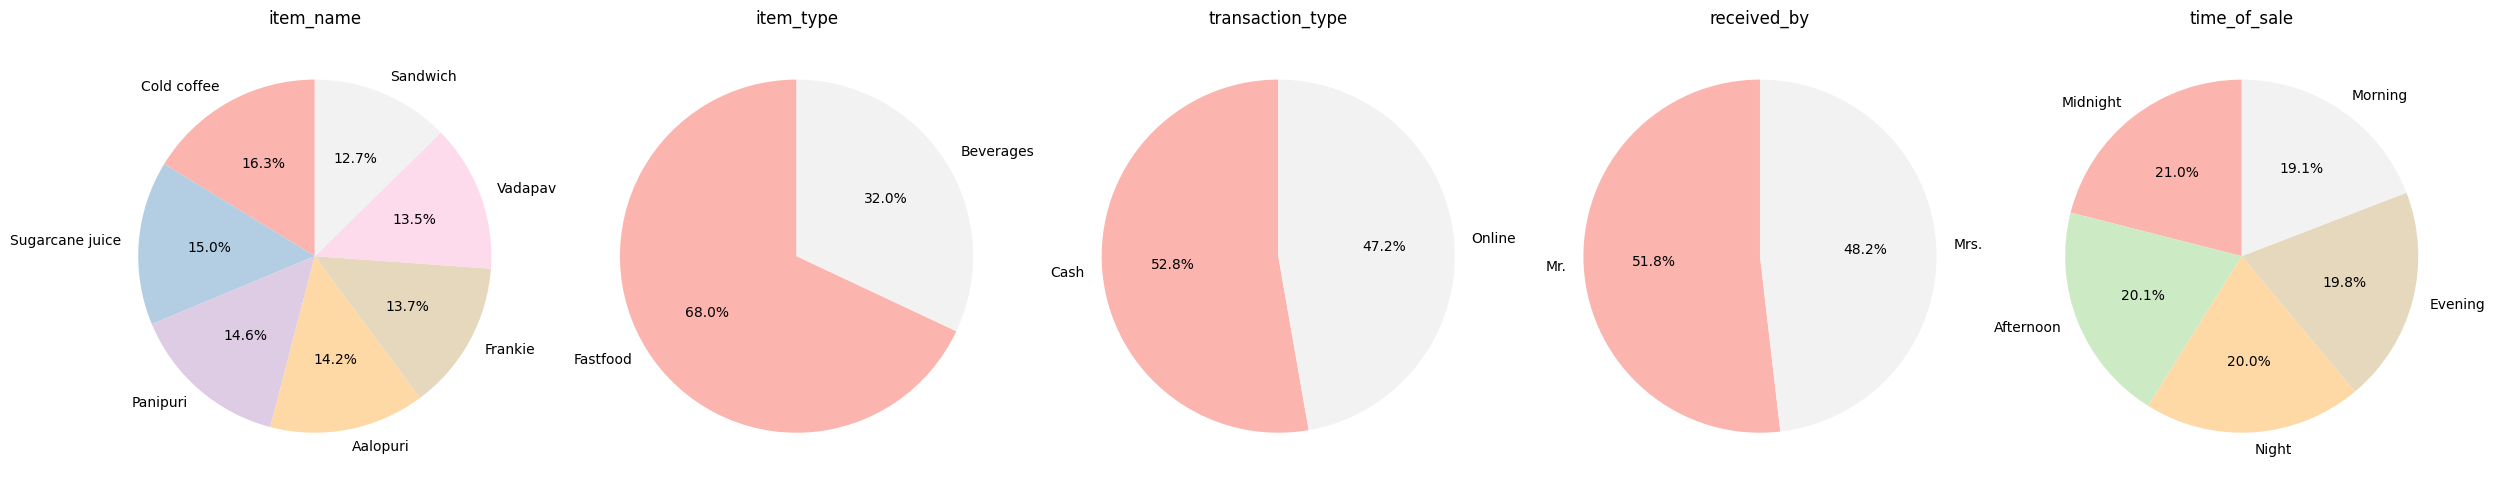

In [ ]:
n_cols = len(categorical_cols)
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(5 * n_cols, 5))

for i, col in enumerate(categorical_cols):
    # Calculate percentage
    pct_df = calculate_percentage(df, col)

    pandas_df = pct_df.toPandas()
    labels = pandas_df[col].tolist()
    sizes = pandas_df["percentage"].tolist()

    colors = plt.cm.Pastel1(np.linspace(0, 1, len(sizes)))
    ax = axes[i] if n_cols > 1 else axes
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 10}
    )

    ax.set_title(f"{col}", fontsize=12)
    ax.axis('equal')

plt.tight_layout()
plt.show()


## Data Transformation

**Handle outlier**

In [ ]:
# numeric columns
numeric_cols = ["item_price", "quantity", "transaction_amount"]

outlier_info = {}

# Calculate statistical values and the number of outliers.
for col_name in numeric_cols:
    # Calculate Q1, Q3, and IQR for each column
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    if len(quantiles) < 2:
        continue
    Q1, Q3 = quantiles
    IQR = Q3 - Q1

    # Calculate the range without outliers.
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outlier values
    outliers = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))

    # Calculate the number of outliers.
    outlier_count = outliers.count()

    # Save information about the statistical values and outliers.
    outlier_info[col_name] = {
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outlier Count": outlier_count,
        "Outlier Data": outliers  # Lưu luôn DataFrame để in ra sau
    }

for col_name, stats in outlier_info.items():
    print(f"Column: {col_name}")
    print(f"  Q1: {stats['Q1']}")
    print(f"  Q3: {stats['Q3']}")
    print(f"  IQR: {stats['IQR']}")
    print(f"  Lower Bound: {stats['Lower Bound']}")
    print(f"  Upper Bound: {stats['Upper Bound']}")
    print(f"  Outlier Count: {stats['Outlier Count']}\n")

    print(f"Outliers for column: {col_name}")
    stats["Outlier Data"].show(truncate=False)


Column: item_price
  Q1: 20.0
  Q3: 40.0
  IQR: 20.0
  Lower Bound: -10.0
  Upper Bound: 70.0
  Outlier Count: 0

Outliers for column: item_price
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|date|item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+

Column: quantity
  Q1: 5.0
  Q3: 12.0
  IQR: 7.0
  Lower Bound: -5.5
  Upper Bound: 22.5
  Outlier Count: 0

Outliers for column: quantity
+----+---------+---------+----------+--------+------------------+----------------+-----------+------------+
|date|item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+----+---------+---------+----------+--------+------------------+-

In [ ]:

from functools import reduce

# Create a list of conditions to remove outliers.
filter_conditions = []

for col_name in numeric_cols:
    stats = outlier_info[col_name]
    lower = stats["Lower Bound"]
    upper = stats["Upper Bound"]
    condition = (col(col_name) >= lower) & (col(col_name) <= upper)
    filter_conditions.append(condition)

# Combine conditions
combined_condition = reduce(lambda x, y: x & y, filter_conditions)

df_no_outliers = df.filter(combined_condition)

# Check the row count before and after removing outliers
print(f"Original row count: {df.count()}")
print(f"Row count after removing outliers: {df_no_outliers.count()}")


Original row count: 14372
Row count after removing outliers: 14154



📊 Column: item_price
Skewness: 0.68


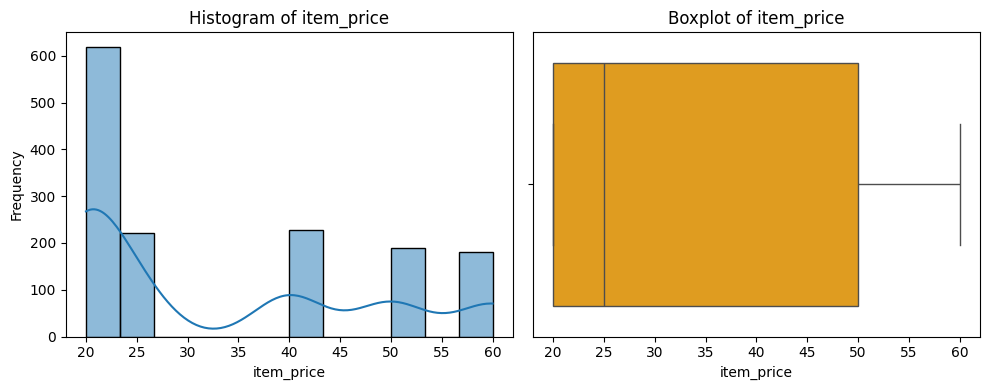


📊 Column: quantity
Skewness: -0.05


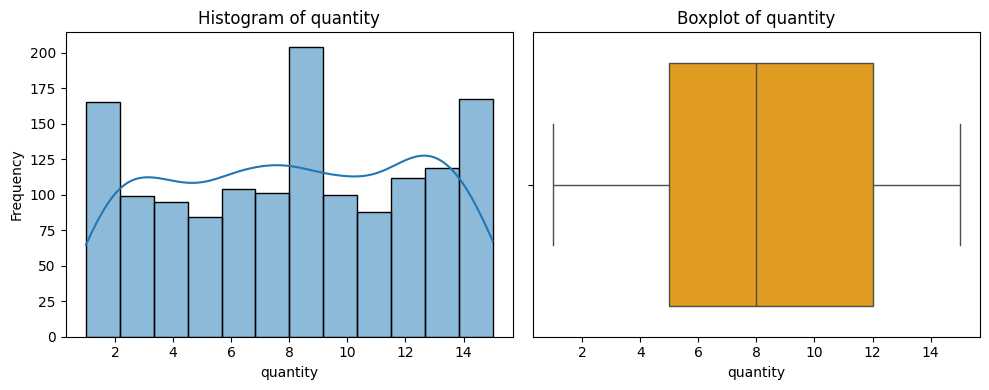


📊 Column: transaction_amount
Skewness: 0.63


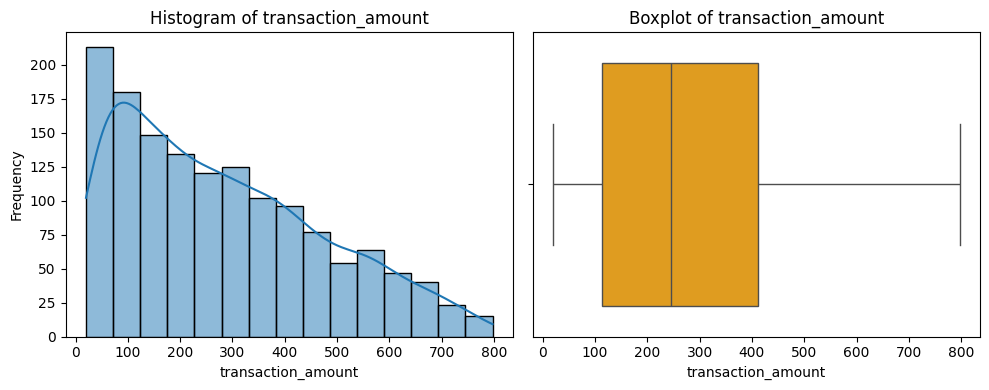

In [ ]:
# Check again

numeric_cols = ["item_price", "quantity", "transaction_amount"]

# SAMPLING FROM SPARK DATAFRAME TO PANDAS
pandas_df = df_no_outliers.sample(withReplacement=False, fraction=0.1, seed=1).toPandas()

# NUMERICAL VARIABLE ANALYSIS
for col in numeric_cols:
    print(f"\n📊 Column: {col}")
    print("Skewness:", round(pandas_df[col].skew(), 2))

    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(pandas_df[col].dropna(), kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=pandas_df[col].dropna(), color='orange')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


**Label Encoding (Mã hóa theo nhãn)**
dùng các thuật toán như cây quyết định (Decision Trees), Random Forest, XGBoost...

In [ ]:
df_no_outliers.describe().show()

+-------+----------+---------+---------+------------------+-----------------+------------------+----------------+-----------+------------+
|summary|      date|item_name|item_type|        item_price|         quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+-------+----------+---------+---------+------------------+-----------------+------------------+----------------+-----------+------------+
|  count|     14154|    14154|    14154|             14154|            14154|             14154|           14154|      14154|       14154|
|   mean|      NULL|     NULL|     NULL| 33.14646036456126|8.168362300409779|283.61989543591915|            NULL|       NULL|        NULL|
| stddev|      NULL|     NULL|     NULL|14.885268345309767|4.180210573058585| 194.0231507967802|            NULL|       NULL|        NULL|
|    min|01-01-2023| Aalopuri|Beverages|                20|                1|                20|            Cash|        Mr.|   Afternoon|
|    max| 9/30/2022|  Vadap

# **Save Data**

In [ ]:
df.coalesce(1) \
    .write.option("header", True) \
    .mode("overwrite") \
    .csv("clean_data")


In [ ]:
df_no_outliers.write.option("header", True).csv("clean_data.csv")


## EDA Bivariate Analysis

In [ ]:
df = df_no_outliers

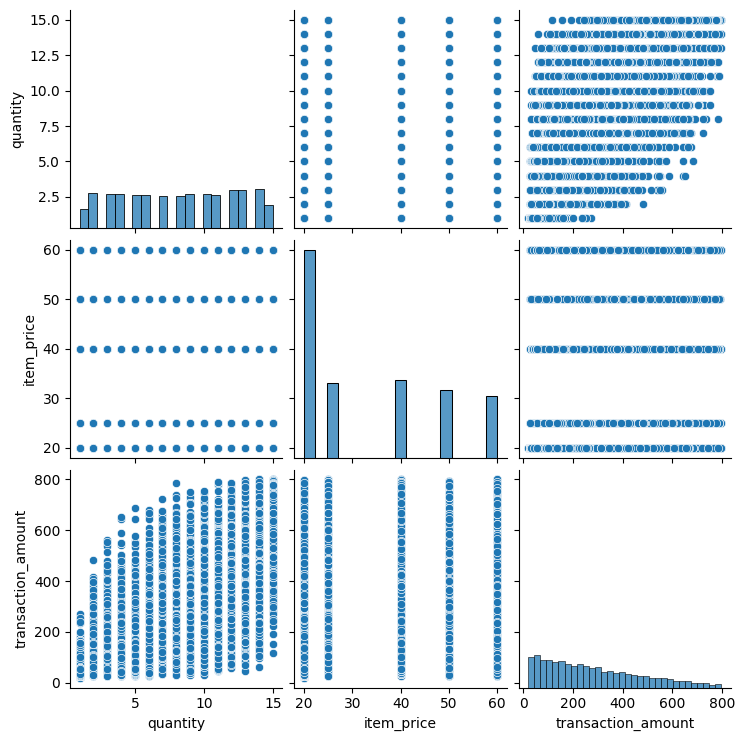

In [ ]:
numeric_columns = [
    'quantity',
    'item_price', 'transaction_amount'
]

pandas_df = df.select(numeric_columns).toPandas()

sns.pairplot(data=pandas_df)
plt.show()


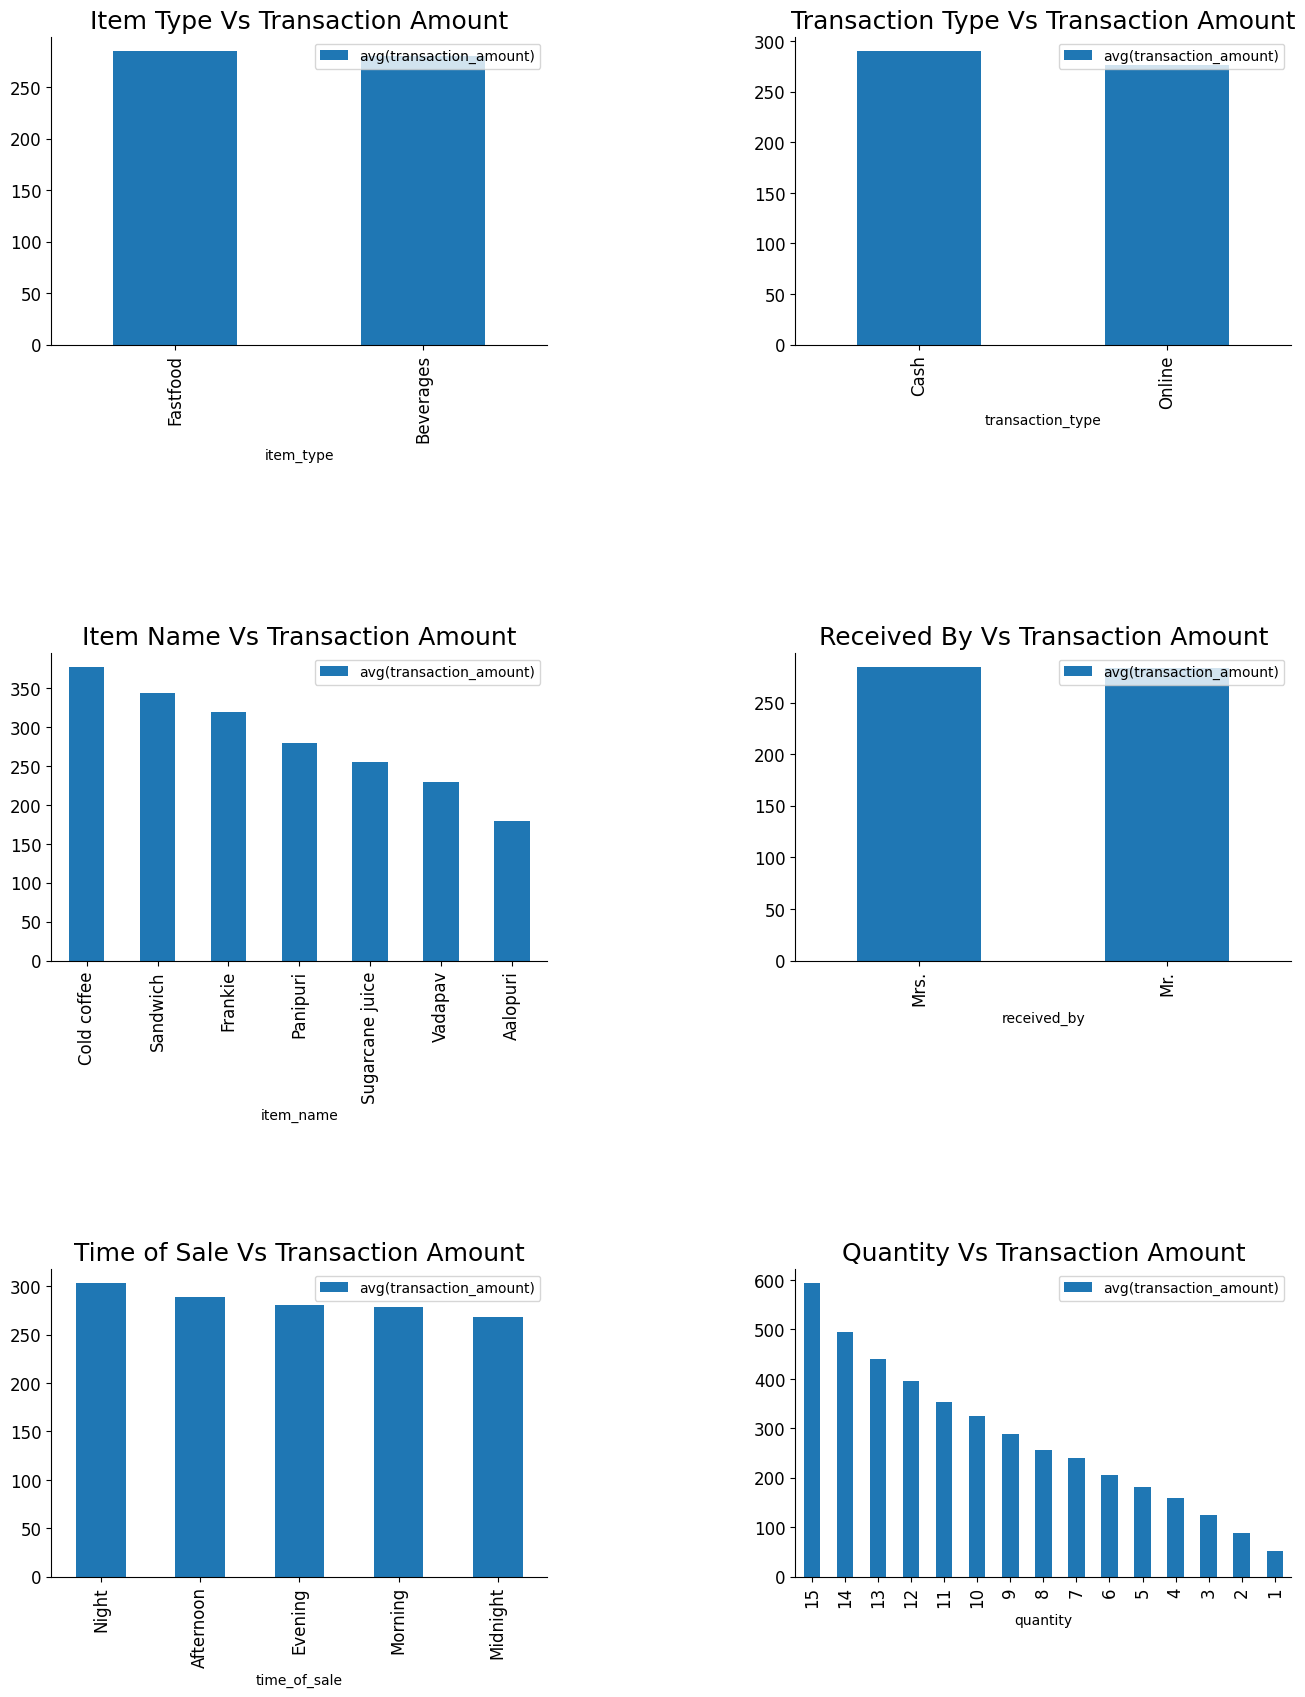

In [ ]:
# Calculate average 'transaction_amount' by group
item_type_avg = df.groupBy('item_type').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).toPandas()
transaction_type_avg = df.groupBy('transaction_type').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).toPandas()
item_name_avg = df.groupBy('item_name').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).limit(10).toPandas()
received_by_avg = df.groupBy('received_by').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).toPandas()
time_of_sale_avg = df.groupBy('time_of_sale').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).limit(10).toPandas()
quantity_avg = df.groupBy('quantity').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).toPandas()
# transaction_amount_avg = df.groupBy('transaction_amount').avg('transaction_amount').orderBy('avg(transaction_amount)', ascending=False).toPandas()

# Plot the chart
fig, axarr = plt.subplots(3, 2, figsize=(16, 20))

item_type_avg.plot.bar(x='item_type', y='avg(transaction_amount)', ax=axarr[0][0], fontsize=12)
axarr[0][0].set_title("Item Type Vs Transaction Amount", fontsize=18)

transaction_type_avg.plot.bar(x='transaction_type', y='avg(transaction_amount)', ax=axarr[0][1], fontsize=12)
axarr[0][1].set_title("Transaction Type Vs Transaction Amount", fontsize=18)

item_name_avg.plot.bar(x='item_name', y='avg(transaction_amount)', ax=axarr[1][0], fontsize=12)
axarr[1][0].set_title("Item Name Vs Transaction Amount", fontsize=18)

received_by_avg.plot.bar(x='received_by', y='avg(transaction_amount)', ax=axarr[1][1], fontsize=12)
axarr[1][1].set_title("Received By Vs Transaction Amount", fontsize=18)

time_of_sale_avg.plot.bar(x='time_of_sale', y='avg(transaction_amount)', ax=axarr[2][0], fontsize=12)
axarr[2][0].set_title("Time of Sale Vs Transaction Amount", fontsize=18)

quantity_avg.plot.bar(x='quantity', y='avg(transaction_amount)', ax=axarr[2][1], fontsize=12)
axarr[2][1].set_title("Quantity Vs Transaction Amount", fontsize=18)

# transaction_amount_avg.plot.bar(x='transaction_amount', y='avg(transaction_amount)', ax=axarr[3][1], fontsize=12)
# axarr[3][1].set_title("Transaction Amount Vs Transaction Amount", fontsize=18)

plt.subplots_adjust(hspace=1.0)
plt.subplots_adjust(wspace=.5)
sns.despine()
plt.show()


## EDA Multivariate Analysis

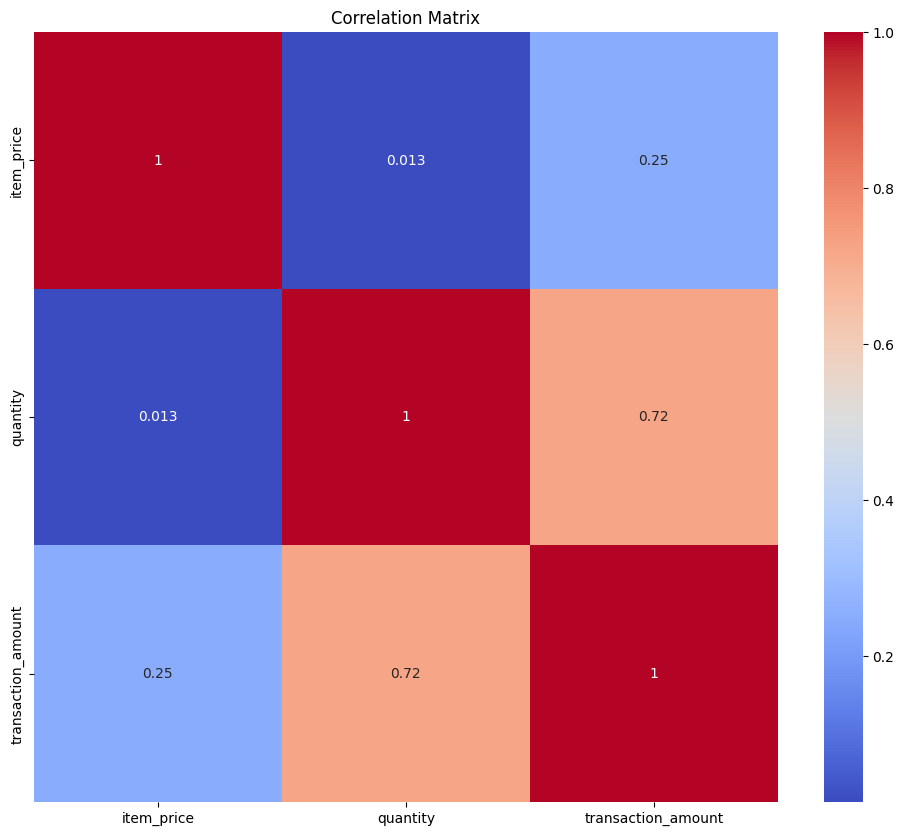

In [ ]:
pandas_df = df.toPandas()
numeric_df = pandas_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Run Model

## Prepare before run model

In [ ]:
spark = SparkSession.builder.appName("RunModel1").getOrCreate()

In [ ]:
df = spark.read.csv("/content/drive/MyDrive/BigData_project/Dataset/clean_data.csv", header=True, inferSchema=True)
df.show()

+----------+---------------+---------+----------+--------+------------------+----------------+-----------+------------+
|      date|      item_name|item_type|item_price|quantity|transaction_amount|transaction_type|received_by|time_of_sale|
+----------+---------------+---------+----------+--------+------------------+----------------+-----------+------------+
| 8/23/2022|        Vadapav| Fastfood|        20|      15|               300|            Cash|        Mr.|   Afternoon|
|11/20/2022|        Vadapav| Fastfood|        20|       1|                20|            Cash|        Mr.|   Afternoon|
|02-03-2023|Sugarcane juice|Beverages|        25|       6|               150|          Online|        Mr.|       Night|
|10-02-2022|Sugarcane juice|Beverages|        25|       8|               200|          Online|        Mr.|     Evening|
|11/14/2022|        Vadapav| Fastfood|        20|      10|               200|            Cash|        Mr.|     Evening|
|05-03-2022|Sugarcane juice|Beverages|  

In [ ]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- item_name: string (nullable = true)
 |-- item_type: string (nullable = true)
 |-- item_price: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- transaction_amount: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- received_by: string (nullable = true)
 |-- time_of_sale: string (nullable = true)



In [ ]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol="item_name", outputCol="item_name_index"),
    StringIndexer(inputCol="item_type", outputCol="item_type_index"),
    StringIndexer(inputCol="transaction_type", outputCol="transaction_type_index"),
    StringIndexer(inputCol="received_by", outputCol="received_by_index"),
    StringIndexer(inputCol="time_of_sale", outputCol="time_of_sale_index")
]

# # Automatically delete output columns if they already exist
# output_cols = [indexer.getOutputCol() for indexer in indexers]
# for col in output_cols:
#     if col in df.columns:
#         df = df.drop(col)

for indexer in indexers:
    df = indexer.fit(df).transform(df)


In [ ]:
col_before_transform = ["item_name", "item_type", "transaction_type", "received_by", "time_of_sale"]
col_after_transform = ["item_name_index", "item_type_index", "transaction_type_index", "received_by_index", "time_of_sale_index"]

df.select(col_before_transform + col_after_transform).show()


+---------------+---------+----------------+-----------+------------+---------------+---------------+----------------------+-----------------+------------------+
|      item_name|item_type|transaction_type|received_by|time_of_sale|item_name_index|item_type_index|transaction_type_index|received_by_index|time_of_sale_index|
+---------------+---------+----------------+-----------+------------+---------------+---------------+----------------------+-----------------+------------------+
|        Vadapav| Fastfood|            Cash|        Mr.|   Afternoon|            5.0|            0.0|                   0.0|              0.0|               2.0|
|        Vadapav| Fastfood|            Cash|        Mr.|   Afternoon|            5.0|            0.0|                   0.0|              0.0|               2.0|
|Sugarcane juice|Beverages|          Online|        Mr.|       Night|            1.0|            1.0|                   1.0|              0.0|               1.0|
|Sugarcane juice|Beverages| 

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["item_price", "quantity", "item_name_index", "item_type_index", "transaction_type_index", "time_of_sale_index"],
    outputCol="features"
)

In [ ]:
assembled_df = assembler.transform(df)
assembled_df.select("item_price", "quantity", "item_name_index", "item_type_index", "transaction_type_index", "time_of_sale_index", "features").show(truncate=False)

+----------+--------+---------------+---------------+----------------------+------------------+---------------------------+
|item_price|quantity|item_name_index|item_type_index|transaction_type_index|time_of_sale_index|features                   |
+----------+--------+---------------+---------------+----------------------+------------------+---------------------------+
|20        |15      |5.0            |0.0            |0.0                   |2.0               |[20.0,15.0,5.0,0.0,0.0,2.0]|
|20        |1       |5.0            |0.0            |0.0                   |2.0               |[20.0,1.0,5.0,0.0,0.0,2.0] |
|25        |6       |1.0            |1.0            |1.0                   |1.0               |[25.0,6.0,1.0,1.0,1.0,1.0] |
|25        |8       |1.0            |1.0            |1.0                   |3.0               |[25.0,8.0,1.0,1.0,1.0,3.0] |
|20        |10      |5.0            |0.0            |0.0                   |3.0               |[20.0,10.0,5.0,0.0,0.0,3.0]|
|25     

###**Split Data**

In [ ]:
df.write.option("header", True).csv("clean_data_num.csv")

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/BigData_project/Dataset/clean_data_num.csv')

# Random data shuffling
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # frac=1 to shuffle everything, random_state to reproduce the result

# Calculate the number of elements for each subset
split_index = int(len(data) * 0.1)  # 10% of total elements

# Create 2 subsets
subset_10 = data.iloc[:split_index]  # Top 10%
subset_90 = data.iloc[split_index:]  # The remaining 90%

print("Bộ dữ liệu 10%:")
print(subset_10)
print("\n Bộ dữ liệu 90%:")
print(subset_90)

# Check number of elements
print("\nSố phần tử trong bộ 10%:", len(subset_10))
print("Số phần tử trong bộ 90%:", len(subset_90))

subset_10.to_csv('Num10.csv', index=False)
subset_90.to_csv('Num90.csv', index=False)


Bộ dữ liệu 10%:
            date        item_name  item_type  item_price  quantity  \
0      5/21/2022          Frankie  Beverages          25        12   
1     04-09-2022          Frankie   Fastfood          50        11   
2      8/22/2022      Cold coffee  Beverages          20         4   
3      5/22/2022         Aalopuri   Fastfood          20         6   
4     05-09-2022         Sandwich   Fastfood          20         7   
...          ...              ...        ...         ...       ...   
1410  01-03-2023  Sugarcane juice   Fastfood          50        15   
1411  01-10-2023      Cold coffee   Fastfood          40         8   
1412   5/20/2022          Frankie   Fastfood          60         9   
1413  04-03-2022      Cold coffee   Fastfood          60         9   
1414  12/25/2022  Sugarcane juice  Beverages          25        11   

      transaction_amount transaction_type received_by time_of_sale  \
0                    611           Online         Mr.     Midnight   
1  

##**Implement algorithms**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

df1 = spark.read.csv("Num90.csv", header=True, inferSchema=True)

# Check and delete the 'features' column if it exists
if 'features' in df1.columns:
    df1 = df1.drop('features')

# Split data into train and test
train_data, test_data = df1.randomSplit([0.8, 0.2], seed=124)

assembler = VectorAssembler(
    inputCols=["item_price", "quantity", "item_name_index", "item_type_index", "transaction_type_index", "time_of_sale_index"],
    outputCol="features"
)

lr = LinearRegression(featuresCol="features", labelCol="transaction_amount")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="transaction_amount")
rf = RandomForestRegressor(featuresCol="features", labelCol="transaction_amount")
gbt = GBTRegressor(featuresCol="features", labelCol="transaction_amount")

# Model evaluation function
def evaluate_model(name, model, train_data, test_data):
    pipeline = Pipeline(stages=[assembler, model])  # Thêm assembler vào pipeline
    fitted_model = pipeline.fit(train_data)
    predictions = fitted_model.transform(test_data)

    # Metrics to evaluate
    metrics = ["r2", "rmse", "mse", "mae"]
    results = {}

    for metric in metrics:
        evaluator = RegressionEvaluator(
            labelCol="transaction_amount",
            predictionCol="prediction",
            metricName=metric
        )
        results[metric.upper()] = evaluator.evaluate(predictions)

    print(f"\nModel: {name}")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

# Review models
models = {
    "LinearRegression": lr,
    "DecisionTree": dt,
    "RandomForest": rf,
    "GBTRegressor": gbt
}

for name, model in models.items():
    evaluate_model(name, model, train_data, test_data)

# Save GBTRegressor model after training
gbt_pipeline = Pipeline(stages=[assembler, gbt])
gbt_model = gbt_pipeline.fit(train_data)
gbt_model.save("models/GBTRegressor")


Model: LinearRegression
R2: 0.5798
RMSE: 125.0029
MSE: 15625.7252
MAE: 97.7077

Model: DecisionTree
R2: 0.6229
RMSE: 118.4199
MSE: 14023.2747
MAE: 91.2098

Model: RandomForest
R2: 0.5888
RMSE: 123.6634
MSE: 15292.6402
MAE: 99.1855

Model: GBTRegressor
R2: 0.6542
RMSE: 113.3948
MSE: 12858.3738
MAE: 86.9520


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import (
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GBTRegressor
)
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

df1 = spark.read.csv("Num90.csv", header=True, inferSchema=True)

if 'features' in df1.columns:
    df1 = df1.drop('features')

train_data, test_data = df1.randomSplit([0.8, 0.2], seed=124)

assembler = VectorAssembler(
    inputCols=["item_price", "quantity", "item_name_index", "item_type_index", "transaction_type_index", "time_of_sale_index"],
    outputCol="features"
)

lr = LinearRegression(featuresCol="features", labelCol="transaction_amount")
dt = DecisionTreeRegressor(featuresCol="features", labelCol="transaction_amount")
rf = RandomForestRegressor(featuresCol="features", labelCol="transaction_amount")
gbt = GBTRegressor(featuresCol="features", labelCol="transaction_amount")

# Model evaluation function
def evaluate_model(name, model, train_data, test_data):
    pipeline = Pipeline(stages=[assembler, model])
    fitted_model = pipeline.fit(train_data)
    predictions = fitted_model.transform(test_data)

    metrics = ["r2", "rmse", "mse", "mae"]
    results = {}

    for metric in metrics:
        evaluator = RegressionEvaluator(
            labelCol="transaction_amount",
            predictionCol="prediction",
            metricName=metric
        )
        results[metric.upper()] = evaluator.evaluate(predictions)

    print(f"\nModel: {name}")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

# Evaluate models and save them
models = {
    "LinearRegression": lr,
    "DecisionTree": dt,
    "RandomForest": rf,
    "GBTRegressor": gbt
}

for name, model in models.items():
    # Đánh giá mô hình
    evaluate_model(name, model, train_data, test_data)

    # Lưu mô hình
    model_pipeline = Pipeline(stages=[assembler, model])
    trained_model = model_pipeline.fit(train_data)
    trained_model.write().overwrite().save(f"models/{name}")



Model: LinearRegression
R2: 0.5798
RMSE: 125.0029
MSE: 15625.7252
MAE: 97.7077

Model: DecisionTree
R2: 0.6229
RMSE: 118.4199
MSE: 14023.2747
MAE: 91.2098

Model: RandomForest
R2: 0.5888
RMSE: 123.6634
MSE: 15292.6402
MAE: 99.1855

Model: GBTRegressor
R2: 0.6542
RMSE: 113.3948
MSE: 12858.3738
MAE: 86.9520


## **Evaluation**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import PipelineModel

# Load data 10%
df10 = spark.read.csv("Num10.csv", header=True, inferSchema=True)

model_names = ["LinearRegression", "DecisionTree", "RandomForest", "GBTRegressor"]

metrics = ["r2", "rmse", "mse", "mae"]

# Browse through each model, load and evaluate
for name in model_names:
    print(f"\n📌 Model: {name}")

    model_path = f"models/{name}"
    model = PipelineModel.load(model_path)

    predictions = model.transform(df10)

    for metric in metrics:
        evaluator = RegressionEvaluator(
            labelCol="transaction_amount",
            predictionCol="prediction",
            metricName=metric
        )
        value = evaluator.evaluate(predictions)
        print(f"{metric.upper()}: {value:.4f}")


📌 Model: LinearRegression
R2: 0.5934
RMSE: 123.9873
MSE: 15372.8615
MAE: 96.7137

📌 Model: DecisionTree
R2: 0.6188
RMSE: 120.0552
MSE: 14413.2590
MAE: 92.7610

📌 Model: RandomForest
R2: 0.5876
RMSE: 124.8606
MSE: 15590.1646
MAE: 100.6910

📌 Model: GBTRegressor
R2: 0.6560
RMSE: 114.0463
MSE: 13006.5576
MAE: 87.6364


**END**